# Text Generation using Tensorflow LSTM

## Importing libraries
- `numpy` : for batch feeding
- `nltk` : for tokenizing the sentences into words
- `re` : for cleaning text
- `collections` : deque, for generating text
- `random` : to generated randomness in training data
- `mtplotlib` : for Loss ploting

In [1]:
import numpy as np
from nltk import word_tokenize
import re
import collections
import random
import matplotlib.pyplot as plt

## Reading text from File

In [2]:
print("Reading file . . .")
f = open("book.txt", "r")
val = f.readlines()
f.close()
print("File read complete!")

Reading file . . .
File read complete!


## Cleaning and Preparing data
### Steps
- text converted to lower case
- removed extra empty lines
- generated spaces between punctuations
- tokenizing text into words
- creating dictionaries for `word_to_index` and vice-versa
- conerting text to indexed data for feeding into LSTM model

In [3]:
print("Cleaning and preparing data. . .")
z = [x.strip().lower() for x in val]
full = []
j = 0
for i in range(len(z)):
    if(z[i] == ''):
        full.append(z[j:i])
        j = i

for val in full:
    for i, part in enumerate(val):
        if part == "":
            del(val[i])

data = []
for val in full:
    data.append(' '.join(val))

for i in range(len(data)):
    data[i] = re.sub("[.]", " .", data[i])

pdata = []
for sent in data:
    x = word_tokenize(sent)
    x.insert(0, "<go>")
    x.append("<eos>")
    pdata.append(x)
    
temp = [item for sublist in pdata for item in sublist]

word_to_idx = {"<go>" : 0, "<eos>" : 1}
total_words = set(word_tokenize(" ".join(temp)))

for word in total_words:
    word_to_idx[word] = len(word_to_idx)
    
idx_to_word = dict(zip(word_to_idx.values(), word_to_idx.keys()))
print("Important Dictionaries Created!!")
print("Total words in text : {}".format(len(word_to_idx)))
print("Converting text to indexed data")
idata = []
for sent in pdata:
    x = list(map(lambda x : word_to_idx[x], sent))
    idata.append(x)
    
original = [item for sublist in pdata for item in sublist]
main = [item for sublist in idata for item in sublist]
print("Conversion Complete!")

Cleaning and preparing data. . .
Important Dictionaries Created!!
Total words in text : 2770
Converting text to indexed data
Conversion Complete!


## Training data generator

In [4]:
class DataGenerator:
    def __init__(self, dataset, batch_size = 10, seq_len = 5, next_predict = 1):
        self.batch_size = batch_size
        self.data = dataset
        self.current_idx = 0
        self.seq_len = seq_len
        self.next_predict = next_predict
        
    def getBatch(self):
        x = np.zeros((self.batch_size, self.seq_len))
        y = np.zeros((self.batch_size, self.next_predict))
        while True:
            if(self.current_idx + self.seq_len * self.batch_size >= len(self.data)):
                self.current_idx = 0
            for i in range(self.batch_size):
                #print(self.current_idx, self.seq_len, self.next_predict)
                x[i, :] = self.data[self.current_idx : self.current_idx + self.seq_len]
                y[i, :] = self.data[self.current_idx + self.seq_len: self.current_idx + self.seq_len + self.next_predict]
                self.current_idx += self.next_predict
            yield x, y

### Sample output of data generator

In [5]:
ss = DataGenerator(main, 5, 5)

x, y = next(ss.getBatch())
print(x)
print(y)

[[   0. 1163. 1194. 1052.  280.]
 [1163. 1194. 1052.  280.  459.]
 [1194. 1052.  280.  459. 2085.]
 [1052.  280.  459. 2085. 1659.]
 [ 280.  459. 2085. 1659.  273.]]
[[ 459.]
 [2085.]
 [1659.]
 [ 273.]
 [ 835.]]


# Tensorflow Model

In [6]:
import tensorflow as tf

c:\users\acer\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Inference function

In [7]:
def generate_text(s, count = 1, training = True):
    x_val = collections.deque(maxlen = 10)
    x_val.append(0)
    generated = []
    eos_count = 0
    word_count = 0
    if(training):
        while eos_count < count and word_count < 50:
            a = s.run(out, feed_dict = {inputs : [x_val]})
            generated.append(idx_to_word[a[0]])
            x_val.append(a[0])
            if(a[0] == 1):
                eos_count += 1
            word_count += 1
    else:
        while eos_count < count:
            a = s.run(out, feed_dict = {inputs : [x_val]})
            generated.append(idx_to_word[a[0]])
            x_val.append(a[0])
            if(a[0] == 1):
                eos_count += 1
            word_count += 1

    #print(" ".join(generated))
    return " ".join(generated)

## Training cell

In [8]:
MAX_TIME = 10
BATCH_SIZE = 15
SAMPLE_SIZE = 5
INPUT_DEPTH = 300
OUTPUT_DIM = 128
VOCAB_SIZE = len(word_to_idx)
LOSS = []
ss = DataGenerator(main, BATCH_SIZE, MAX_TIME)

inputs = tf.placeholder(shape=[None, None], dtype=tf.int32, name="Idata")
outputs = tf.placeholder(shape=[None, None], dtype=tf.int32, name="Odata")

W = tf.Variable(tf.random_normal(shape=[OUTPUT_DIM, VOCAB_SIZE], name="W", dtype=tf.float32))
b = tf.Variable(tf.random_normal(shape=[VOCAB_SIZE], name="b", dtype=tf.float32))

embeddings = tf.get_variable(name="embeddings", shape=[VOCAB_SIZE, INPUT_DEPTH], initializer=tf.glorot_uniform_initializer())
out = tf.nn.embedding_lookup(embeddings, inputs)

cell = tf.nn.rnn_cell.BasicLSTMCell(OUTPUT_DIM)
op, state = tf.nn.dynamic_rnn(cell, out, dtype=tf.float32)

max_steps, batch_size, dim = tf.unstack(tf.shape(op))

flat = tf.reshape(op, (-1, OUTPUT_DIM), name="Wassup")
logits = tf.matmul(flat, W) + b
back = tf.reshape(logits, (max_steps, batch_size, VOCAB_SIZE), name="Done")

out = tf.argmax(back[:, -1, :], 1)

stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(outputs, depth=VOCAB_SIZE, dtype=tf.float32),
    logits=back[:, -1, :],
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
print("Training Start")
for i in range(100):
    for j in range(len(main) // 25):
        z = random.sample(list(range(BATCH_SIZE)), 5)
        x, y = next(ss.getBatch())
        x = x[z]
        y = y[z]
        a, l, _ = sess.run([out, loss, train_op], feed_dict = {inputs : x, outputs : y})
    LOSS.append(l)
    if(i + 1) % 10 == 0:
        print("Iteration {}, Loss : {:.2f}".format(i+1, l))
        print("Sample Text :\n")
        x = generate_text(sess)
        print("".join(x.replace("<go>", " ").split("<eos>")))
        
print("Training Ended")

Training Start
Iteration 10, Loss : 4.36
Sample Text :

“ i got and the place , for for instance , they taught you that would be convenient to be convenient to be sat and down . it was so , and i got to my mind . 
Iteration 20, Loss : 2.34
Sample Text :

“ but you can not move about in time . ” 
Iteration 30, Loss : 0.08
Sample Text :

“ there is the means of inactive for twenty-four , ” said the time traveller . “ what on a large buildings towards the score of were little people have no fame of the ) and three of cheerfully . things came clear to me . what on the idea
Iteration 40, Loss : 0.48
Sample Text :

“ there is the hail curtain , having only being me . then of it is odd , too , how how she would be suddenly as along their bronze abundant , and white an sound speaker . ’ 
Iteration 50, Loss : 0.08
Sample Text :

“ and there were , mattered , i pointed to the sun . at once a quaintly pretty little figure in chequered purple and white followed my gesture , and then astonished me 

## Plotting Loss

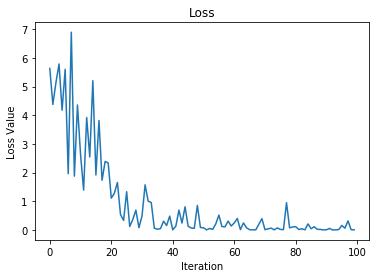

In [9]:
plt.plot(list(range(100)), LOSS)
plt.title("Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss Value")
plt.show()

## Text generated after training

In [10]:
x = generate_text(sess, 10, training = False)

In [11]:
"".join(x.replace("<go>", " ").split("<eos>"))

'“ there was no trickery . i don ’ t want to waste this model , and then be told i ’ m a quack . ”    there was a minute ’ s pause perhaps . the psychologist seemed about to speak to me , but changed his mind . then the time traveller put forth his finger towards the lever .    “ no , ” he said .    “ yes , so the seemed to me , and so i never talked of it until— ”    “ experimental verification ! ” cried i . “ you are going to verify _that_ ? ”    “ the experiment ! ” cried filby , who was getting brain-weary .    “ let ’ s see your experiment anyhow , ” said the psychologist , “ though it ’ s all humbug , you know . ”    the time traveller smiled round at us , as we are did not so . but wait inactive for twenty-four hours—that is another matter .    “ i got up after all , a time , and began walking aimlessly through the bushes towards the hill again . ‘ patience , ’ said i to myself . ‘ if you want your machine again you must leave that sphinx alone . if they mean to take your machin